### Before running the Model

In [1]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana as pdn
import pickle as pkl

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories (Si no existen se crean)
for d in ["data", "logs", "models", "networks"]:
    if not os.path.isdir(d):
        os.mkdir(d)

In [2]:
trips = pd.read_csv(f'SEMS_NO_SEMS_OK.csv',sep=";")

In [3]:
#Seleccionar las columna que queremos del fichero
trips = trips[
    ['NIVEL', 'CICLO', 'Centro', 'Promedio', 'SEXO', 'EDAD',
     '¿EN QUÉ MUNICIPIO VIVES?', '¿CÓMO ACOSTUMBRAS A IR DE TU CASA A LA ESCUELA?',
     '¿CUÁNTO TIEMPO HACES DE TU CASA A LA ESCUELA?', '¿CUÁL ES TU SITUACIÓN CONYUGAL?',
     '¿TIENES HIJOS?', 'CÚANTAS PERSONAS, ADEMÁS DE TI, ¿HABITAN EN TU VIVIENDA?',
     '¿CUÁNTOS AUTOMÓVILES O CAMIONETAS TIENEN EN TU HOGAR, INCLUYENDO CAMIONETAS CERRADAS, O CON CABINA O CAJA?',
     'AHORA, AYUDANOS A CONOCER EL MONTO PROMEDIO DE INGRESOS TRIMESTRALES DE TU HOGAR  	Selecciona la opción de monto de ingresos que más se acerque al ingreso trimestral de todos los miembros del hogar',
     '¿DE QUE MATERIAL ES EL PISO DE TU CASA?', '¿TU CASA DISPONE DE AGUA ENTUBADA?',
     'EN TU CASA, ¿DE DÓNDE OBTIENEN LA LUZ ELÉCTRICA?',
     '¿ERES EL PRIMER INTEGRANTE DE TU FAMILIA INMEDIATA (PADRES Y/O HERMANOS) EN ASISTIR A LA UNIVERSIDAD?',
      'Latitud', 'Longitud',
     'Centro específico', 'Latitud_centro', 'Longitud_centro','Nombre de la colonia', 'drive_weight', 'walk_weight','transit_weight']
]

print (trips.head())

trips = trips.rename(columns={'¿EN QUÉ MUNICIPIO VIVES?': 'MUNICIPIO'})
trips = trips.rename(columns={'¿CÓMO ACOSTUMBRAS A IR DE TU CASA A LA ESCUELA?': 'Modo transporte'})
trips = trips.rename(columns={'¿CUÁNTO TIEMPO HACES DE TU CASA A LA ESCUELA?': 'Tiempo origen-destino'})
trips = trips.rename(columns={'¿CUÁL ES TU SITUACIÓN CONYUGAL?': 'Situacion conyugal'})
trips = trips.rename(columns={'CÚANTAS PERSONAS, ADEMÁS DE TI, ¿HABITAN EN TU VIVIENDA?': 'Personas en la vivienda'})
trips = trips.rename(columns={'¿CUÁNTOS AUTOMÓVILES O CAMIONETAS TIENEN EN TU HOGAR, INCLUYENDO CAMIONETAS CERRADAS, O CON CABINA O CAJA?': 'Automoviles o camionetas en el hogar incluyendo cabina o caja'})
trips = trips.rename(columns={'AHORA, AYUDANOS A CONOCER EL MONTO PROMEDIO DE INGRESOS TRIMESTRALES DE TU HOGAR  	Selecciona la opción de monto de ingresos que más se acerque al ingreso trimestral de todos los miembros del hogar': 'Ingreso trimestral de todos los miembros del hogar'})
trips = trips.rename(columns={'¿DE QUE MATERIAL ES EL PISO DE TU CASA?': 'Material del piso de la casa'})
trips = trips.rename(columns={'¿TU CASA DISPONE DE AGUA ENTUBADA?': 'Agua entubada en la casa'})
trips = trips.rename(columns={'¿TIENES HIJOS?': 'HIJOS'})
trips = trips.rename(columns={'EN TU CASA, ¿DE DÓNDE OBTIENEN LA LUZ ELÉCTRICA?': 'Luz electrica en la casa'})
trips = trips.rename(columns={'¿ERES EL PRIMER INTEGRANTE DE TU FAMILIA INMEDIATA (PADRES Y/O HERMANOS) EN ASISTIR A LA UNIVERSIDAD?': 'Primer integrante de la familia en asistir a la universidad'})



          NIVEL  CICLO Centro  Promedio   SEXO  EDAD ¿EN QUÉ MUNICIPIO VIVES?  \
0  LICENCIATURA      5  CUCEA        93  Mujer    22                   TONALA   

  ¿CÓMO ACOSTUMBRAS A IR DE TU CASA A LA ESCUELA?  \
0                           Public Transportation   

   ¿CUÁNTO TIEMPO HACES DE TU CASA A LA ESCUELA?  \
0                                              2   

  ¿CUÁL ES TU SITUACIÓN CONYUGAL?  ...  \
0                         Soltero  ...   

  ¿ERES EL PRIMER INTEGRANTE DE TU FAMILIA INMEDIATA (PADRES Y/O HERMANOS) EN ASISTIR A LA UNIVERSIDAD?  \
0                                                 NO                                                      

     Latitud    Longitud                                  Centro específico  \
0  20.645153 -103.266092  CENTRO UNIVERSITARIO DE CIENCIAS EXACTAS E ING...   

  Latitud_centro Longitud_centro Nombre de la colonia drive_weight  \
0       20.65389      -103.32592        La Ladrillera           20   

   walk_weight  transit_w

In [4]:
#Establecer rangos en los ingresos (de string a numerico)
trips['Ingreso trimestral de todos los miembros del hogar'] = trips['Ingreso trimestral de todos los miembros del hogar'].replace({"$0 a $9,113": 1, "$9,114 a $16,100": 2,"$16,101 a $21,428":3, "$21,429 a $26,696":4,"$26,697 a $32,318":5, "$32,319 a $38,957":6, "$38,958 a $47,264":7, "$47,265 a $58,885":8, "$58,886 a $78,591":9, "$78,592 a $166,750":10 })

print(trips['Ingreso trimestral de todos los miembros del hogar'].unique())


trips['Automoviles o camionetas en el hogar incluyendo cabina o caja'] = trips['Automoviles o camionetas en el hogar incluyendo cabina o caja'].replace({"2 ó más":2,"1":1, "0":0})
print(trips['Automoviles o camionetas en el hogar incluyendo cabina o caja'].unique())

trips['Personas en la vivienda'] = trips['Personas en la vivienda'].replace({"Vivo solo":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"10":10,"Mas de 10":11 })
print(trips['Personas en la vivienda'].unique())

[8]
[1]
[2]


C:\Users\Edu Bilbao\AppData\Local\Temp\ipykernel_17020\1466146208.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = trips.corr()
c:\Users\Edu Bilbao\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Edu Bilbao\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


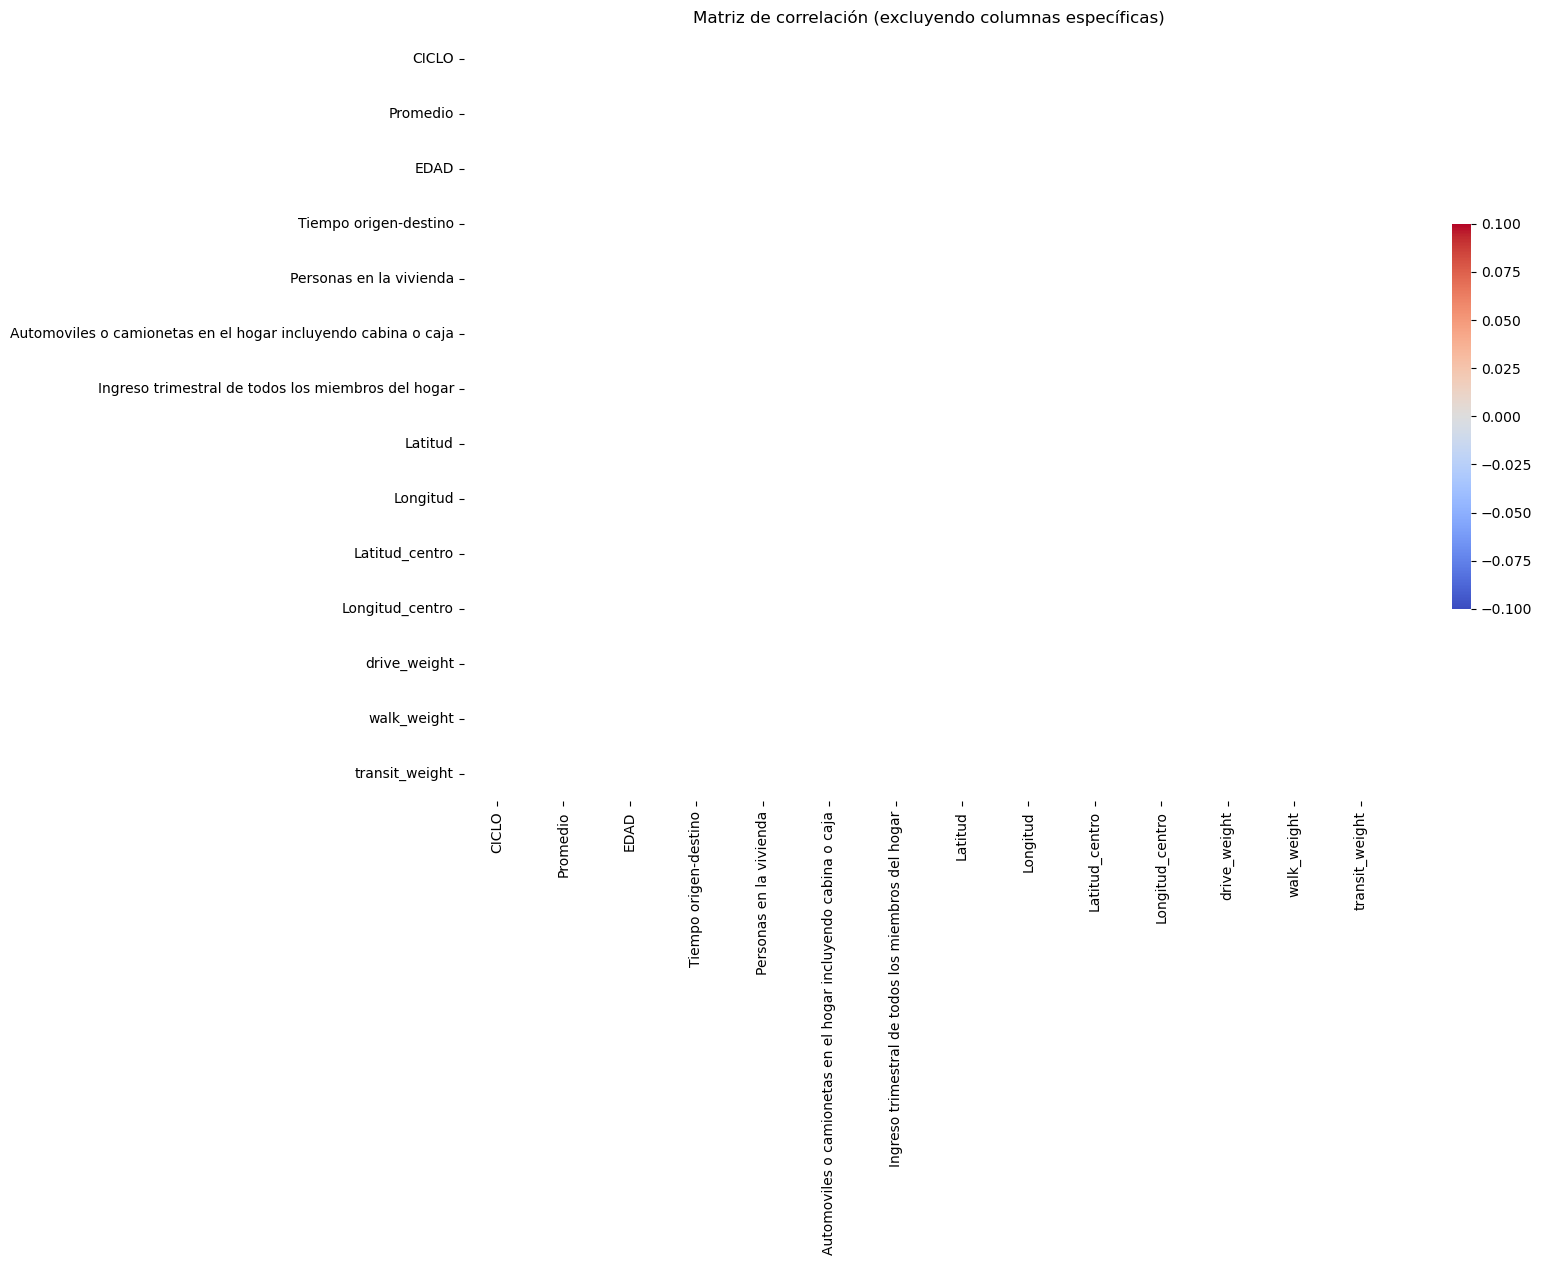

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes para el cálculo de correlación
#columns_to_include = trips.drop(['Tiempo origen-destino', 'Latitud', 'Longitud', 'Latitud_centro', 'Longitud_centro'], axis=1)

# Calcular la matriz de correlación
corr_matrix = trips.corr()

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configurar la figura de matplotlib
plt.figure(figsize=(15, 10))

# Dibujar el mapa de calor
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .5})

plt.title('Matriz de correlación (excluyendo columnas específicas)')
plt.show()


In [7]:
label_encoder = LabelEncoder()
cat_cols = ["Centro", "NIVEL", "SEXO", "Situacion conyugal", "MUNICIPIO", "HIJOS", "Material del piso de la casa", "Agua entubada en la casa", "Luz electrica en la casa", "Primer integrante de la familia en asistir a la universidad", "Centro específico"]

encoding_mapping = {}  # Diccionario para almacenar la correspondencia entre categorías y valores numéricos

for col in cat_cols:
    trips[col] = label_encoder.fit_transform(trips[col])

    # Obtener las reglas de encoding y almacenar en el diccionario
    encoding_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Guardar el encoder usando pickle
    with open(os.path.join("models", "encoders", f'{col}.pkl'), 'wb') as file:
        pkl.dump(label_encoder, file)

# Imprimir el diccionario de correspondencia
print("Correspondencia de encoding:")
for col, mapping in encoding_mapping.items():
    print(f'{col}: {mapping}')

Correspondencia de encoding:
Centro: {0: 0}
NIVEL: {'LICENCIATURA': 0}
SEXO: {'Mujer': 0}
Situacion conyugal: {'Soltero': 0}
MUNICIPIO: {'TONALA': 0}
HIJOS: {'No': 0}
Material del piso de la casa: {'Mosaico, madera u otro recubrimiento': 0}
Agua entubada en la casa: {'Dentro de la vivienda': 0}
Luz electrica en la casa: {'Del servicio público (Comisión Federal de Electricidad)': 0}
Primer integrante de la familia en asistir a la universidad: {'NO': 0}
Centro específico: {'CENTRO UNIVERSITARIO DE CIENCIAS EXACTAS E INGENIERIA': 0}


In [8]:
for p in [f"{label}: {trips[trips['Modo transporte'] == label].shape[0]:,}" for label in trips['Modo transporte'].unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Public Transportation: 1
Total: 1


In [9]:
trips = trips.drop(columns=["Nombre de la colonia"],errors='ignore')

C:\Users\Edu Bilbao\AppData\Local\Temp\ipykernel_17020\2804390211.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = columns_to_include.corr()
c:\Users\Edu Bilbao\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Edu Bilbao\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


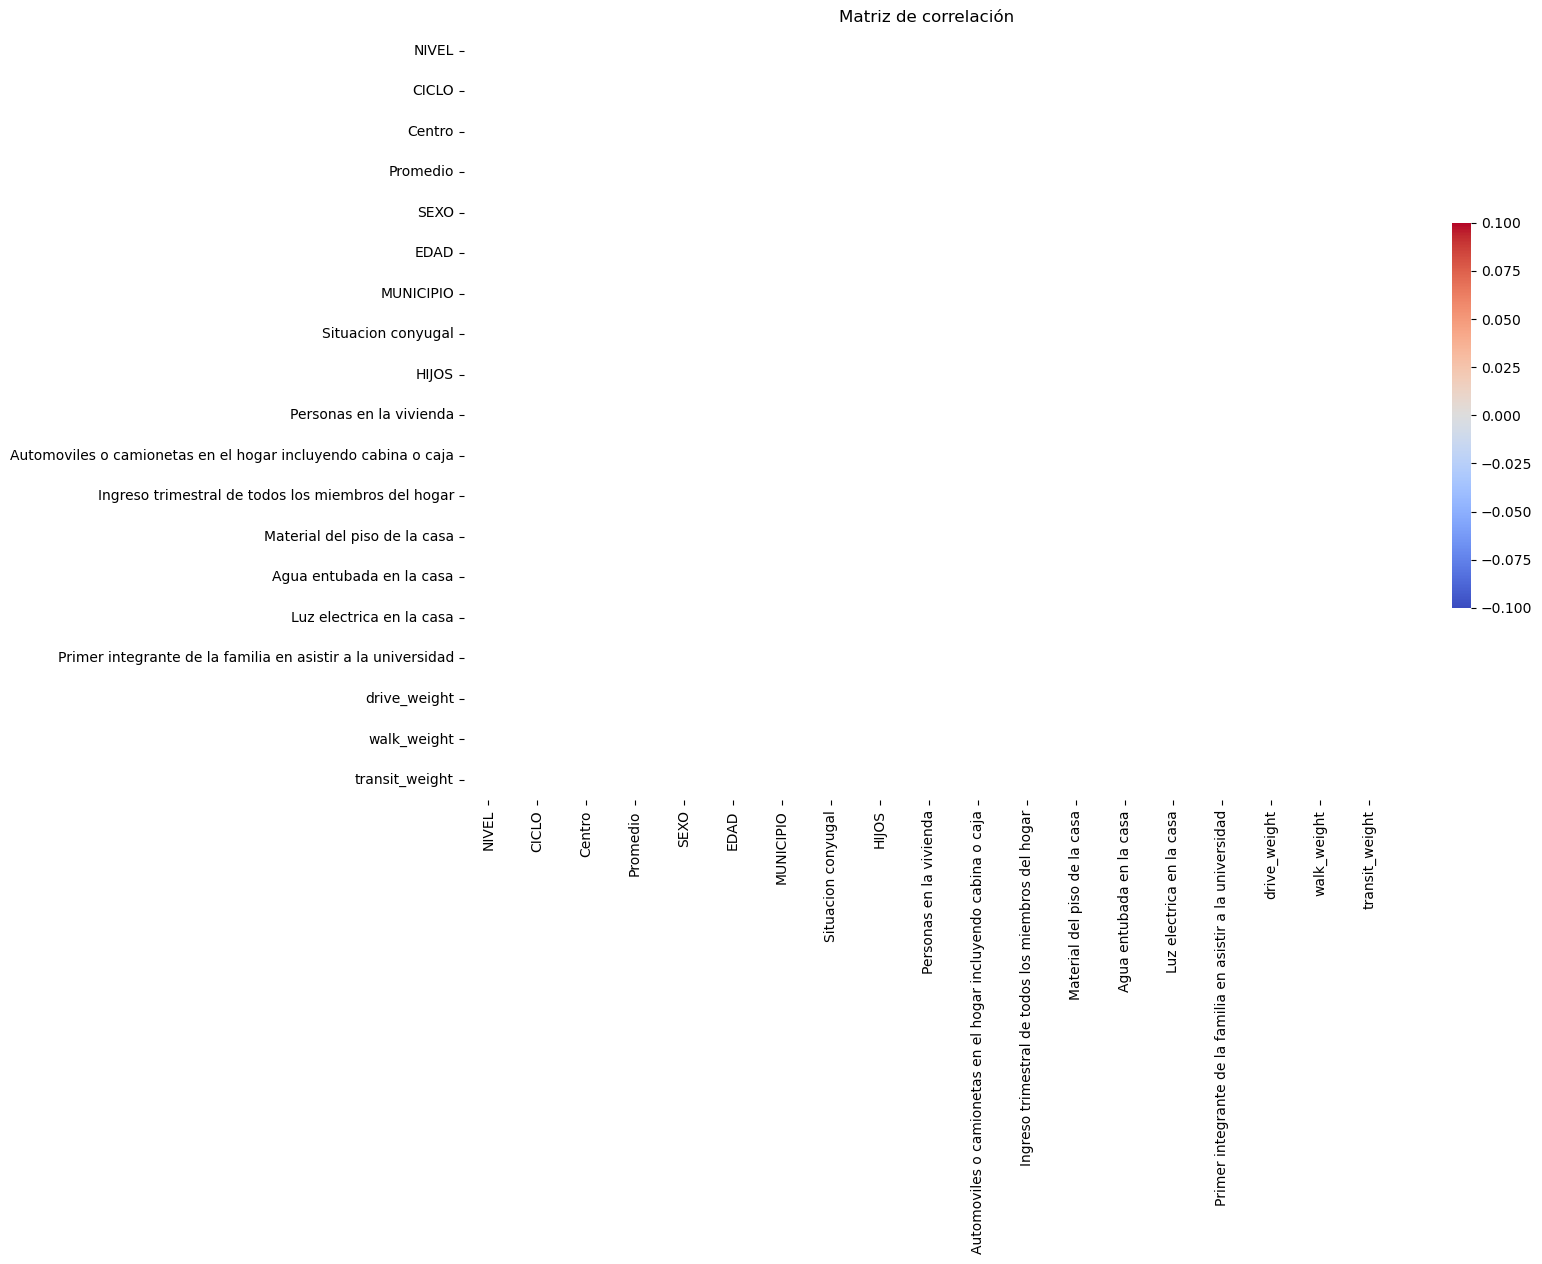

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes para el cálculo de correlación
columns_to_include = trips.drop(['Tiempo origen-destino', 'Latitud', 'Longitud', 'Latitud_centro', 'Longitud_centro','Centro específico'], axis=1)

# Calcular la matriz de correlación
corr_matrix = columns_to_include.corr()

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configurar la figura de matplotlib
plt.figure(figsize=(15, 10))

# Dibujar el mapa de calor
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .5})

plt.title('Matriz de correlación ')
plt.show()

In [11]:
trips.to_csv(f"data/Guadalajara_encoded_SEMS + NO SEMS_OK.csv")